# End To End Demo

This notebooks demonstrates the data flow of generating a graph from a CSV file using Runway v0.9.0

In [1]:
import os

import pandas as pd
from dotenv import load_dotenv

from neo4j_runway import Discovery, GraphDataModeler, PyIngest, UserInput
from neo4j_runway.code_generation import PyIngestConfigGenerator
from neo4j_runway.llm.openai import OpenAIDataModelingLLM, OpenAIDiscoveryLLM
from neo4j_runway.utils import test_database_connection

load_dotenv()

True

## Load and Describe Data

The USER_GENERATED_INPUT variable contains a general discription and feature descriptions for each feature we'd like to use in our graph.

In [2]:
USER_GENERATED_INPUT = UserInput(general_description='This is data on different countries.',
                                 column_descriptions={
                                     'id': 'unique id for a country.',
                                    'name': 'the country name.',
                                    'phone_code': 'country area code.',
                                    'capital': 'the capital of the country.',
                                    'currency_name': "name of the country's currency.",
                                    'region': 'primary region of the country.',
                                    'subregion': 'subregion location of the country.',
                                    'timezones': 'timezones contained within the country borders.',
                                    'latitude': 'the latitude coordinate of the country center.',
                                    'longitude': 'the longitude coordinate of the country center.'
                                    },
                                use_cases=[
        "Which region contains the most subregions?", 
        "What currencies are most popular?", 
        "Which countries share timezones?"
    ]  
                                )

In [3]:
data = pd.read_csv("../../../data/countries/countries.csv")

In [4]:
data.head()

,id,name,iso3,iso2,numeric_code,phone_code,capital,currency,currency_name,currency_symbol,tld,native,region,subregion,timezones,latitude,longitude,emoji,emojiU
0,1,Afghanistan,AFG,AF,4,93,Kabul,AFN,Afghan afghani,؋,.af,افغانستان,Asia,Southern Asia,"[{zoneName:'Asia\/Kabul',gmtOffset:16200,gmtOf...",33.000000,65.0,🇦🇫,U+1F1E6 U+1F1EB
1,2,Aland Islands,ALA,AX,248,+358-18,Mariehamn,EUR,Euro,€,.ax,Åland,Europe,Northern Europe,"[{zoneName:'Europe\/Mariehamn',gmtOffset:7200,...",60.116667,19.9,🇦🇽,U+1F1E6 U+1F1FD
2,3,Albania,ALB,AL,8,355,Tirana,ALL,Albanian lek,Lek,.al,Shqipëria,Europe,Southern Europe,"[{zoneName:'Europe\/Tirane',gmtOffset:3600,gmt...",41.000000,20.0,🇦🇱,U+1F1E6 U+1F1F1
3,4,Algeria,DZA,DZ,12,213,Algiers,DZD,Algerian dinar,دج,.dz,الجزائر,Africa,Northern Africa,"[{zoneName:'Africa\/Algiers',gmtOffset:3600,gm...",28.000000,3.0,🇩🇿,U+1F1E9 U+1F1FF
4,5,American Samoa,ASM,AS,16,+1-684,Pago Pago,USD,US Dollar,$,.as,American Samoa,Oceania,Polynesia,"[{zoneName:'Pacific\/Pago_Pago',gmtOffset:-396...",-14.333333,-170.0,🇦🇸,U+1F1E6 U+1F1F8


## Initialize LLMs

We now initialize the LLMs to use in data discovery and data model creation.

In [5]:
llm_disc = OpenAIDiscoveryLLM(model_name='gpt-4o-mini-2024-07-18', model_params={"temperature": 0})
llm_dm = OpenAIDataModelingLLM(model_name='gpt-4o-2024-05-13', model_params={"temperature": 0.5})

## Discovery

We now load the above data into a Discovery object.

In [6]:
disc = Discovery(llm=llm_disc, user_input=USER_GENERATED_INPUT, data=data)

In [7]:
disc.run(show_result=True, notebook=True)

### Preliminary Analysis of Country Data

#### Overall Data Characteristics:
1. **Data Size**: The dataset contains 250 entries (countries) and 10 features.
2. **Data Types**: The features include integers, floats, and objects (strings). The presence of both numerical and categorical data allows for diverse analyses.
3. **Missing Values**: 
   - `capital`: 5 missing values (2% of the data)
   - `region`: 2 missing values (0.8% of the data)
   - `subregion`: 3 missing values (1.2% of the data)
   - These missing values should be addressed, especially for analyses involving regions and capitals.

#### Important Features:
1. **id**: Unique identifier for each country, useful for referencing.
2. **name**: Country names are unique, which is essential for any country-based analysis.
3. **phone_code**: Indicates the country area code, with 235 unique codes for 250 countries, suggesting some countries share codes.
4. **capital**: Important for geographical and political analyses, though it has some missing values.
5. **currency_name**: With 161 unique currencies, this feature is crucial for economic analyses. The most common currency is the Euro, used by 35 countries.
6. **region**: There are 6 unique regions, with Africa being the most populous (60 countries). This feature is vital for regional analyses.
7. **subregion**: Contains 22 unique subregions, which can provide more granular insights into geographical distributions.
8. **timezones**: This feature has 245 unique entries, indicating that many countries share timezones, which is important for understanding global time coordination.
9. **latitude and longitude**: These geographical coordinates are essential for mapping and spatial analyses.

#### Use Case Insights:
1. **Regions and Subregions**: To determine which region contains the most subregions, we can analyze the `region` and `subregion` features. The region with the highest count of unique subregions will be identified.
2. **Popular Currencies**: The `currency_name` feature can be analyzed to find the most frequently occurring currencies, highlighting economic trends.
3. **Shared Timezones**: The `timezones` feature can be examined to identify countries that share the same timezone, which is crucial for international relations and business operations.

#### Conclusion:
The dataset is rich in information, with several features that can be leveraged for various analyses. The most important features for the specified use cases are `region`, `subregion`, `currency_name`, and `timezones`. Addressing the missing values will enhance the reliability of the analyses.

## Data Modeling

We can now use our Discovery object to provide context to the LLM for data model generation. We don't *need* the discovery information for this step to work, but it provides much better models.

In [8]:
gdm = GraphDataModeler(
    llm=llm_dm,
    discovery=disc
)

We now generate our first pass data model.

In [9]:
gdm.create_initial_model(max_retries=3)

> Generating Nodes...
Attempts | 3  
Received Valid Nodes
Nodes
* (:Country)     * (:Region)
* (:Subregion)   * (:Currency)
* (:Timezone)     

> Generating Data Model...
Attempts | 2  
Recieved Valid Data Model
Nodes
* (:Country)     * (:Region)
* (:Subregion)   * (:Currency)
* (:Timezone)     

Relationships
* (:Subregion)-[:BELONGS_TO]->(:Region)        
* (:Country)-[:USES_CURRENCY]->(:Currency)     
* (:Country)-[:SHARES_TIMEZONE]->(:Timezone)   
* (:Country)-[:LOCATED_IN]->(:Subregion)       


DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='int', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=True, part_of_key=False), Property(name='phoneCode', type='str', column_mapping='phone_code', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', column_mapping='latitude', alias=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', column_mapping='longitude', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='Region', properties=[Property(name='name', type='str', column_mapping='region', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Subregion', properties=[Property(name='name', type='str', column_mapping='subregion'

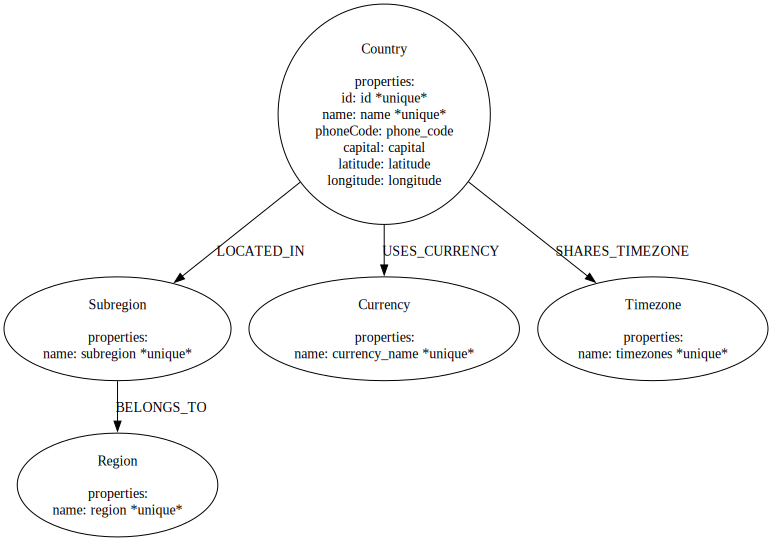

In [10]:
gdm.current_model.visualize()

We can now create some ingestion code to get our data into our database.

## Ingestion Code Generation

We can provide our credentials here in this step if we plan on using PyIngest to load our data. This will inject our credentials into the generated YAML file. If we leave the credential fields blank, then we can just fill in the blanks in the generated YAML file later.

In [11]:
gen = PyIngestConfigGenerator(data_model=gdm.current_model, 
                         username=os.environ.get("NEO4J_USERNAME"), 
                         password=os.environ.get("NEO4J_PASSWORD"), 
                         uri=os.environ.get("NEO4J_URI"), 
                         database=os.environ.get("NEO4J_DATABASE"), 
                         file_directory="data/csv/", source_name="countries.csv")

In [12]:
pyingest_yaml = gen.generate_config_string()
print(pyingest_yaml)

server_uri: bolt://localhost:7687
admin_user: neo4j
admin_pass: password
database: neo4j
basepath: ./

pre_ingest:
  - CREATE CONSTRAINT country_id IF NOT EXISTS FOR (n:Country) REQUIRE n.id IS UNIQUE;
  - CREATE CONSTRAINT country_name IF NOT EXISTS FOR (n:Country) REQUIRE n.name IS UNIQUE;
  - CREATE CONSTRAINT region_name IF NOT EXISTS FOR (n:Region) REQUIRE n.name IS UNIQUE;
  - CREATE CONSTRAINT subregion_name IF NOT EXISTS FOR (n:Subregion) REQUIRE n.name IS UNIQUE;
  - CREATE CONSTRAINT currency_name IF NOT EXISTS FOR (n:Currency) REQUIRE n.name IS UNIQUE;
  - CREATE CONSTRAINT timezone_name IF NOT EXISTS FOR (n:Timezone) REQUIRE n.name IS UNIQUE;
files:
- chunk_size: 100
  cql: |-
    WITH $dict.rows AS rows
    UNWIND rows AS row
    MERGE (n:Country {id: toIntegerOrNull(row.id), name: row.name})
    SET n.phoneCode = row.phone_code, n.capital = row.capital, n.latitude = toFloatOrNull(row.latitude), n.longitude = toFloatOrNull(row.longitude)
  url: $BASE/data/csv/countries.csv

## Ingest Data

We can use the generated yaml string above to orchestrate the data loading via a modified PyIngest function. First let's confirm our connection though.

In [13]:
test_database_connection(credentials={"username": os.environ.get("NEO4J_USERNAME"), "password": os.environ.get("NEO4J_PASSWORD"), "uri": os.environ.get("NEO4J_URI")})

{'valid': True, 'message': 'Connection and Auth Verified!'}

In [14]:
PyIngest(config=pyingest_yaml, dataframe=data)

If we check our database we can see that we've ingested our CSV according to the data model we've created!

![countries-graph-0.9.0.png](../../../images/countries-graph-0.9.0.png)